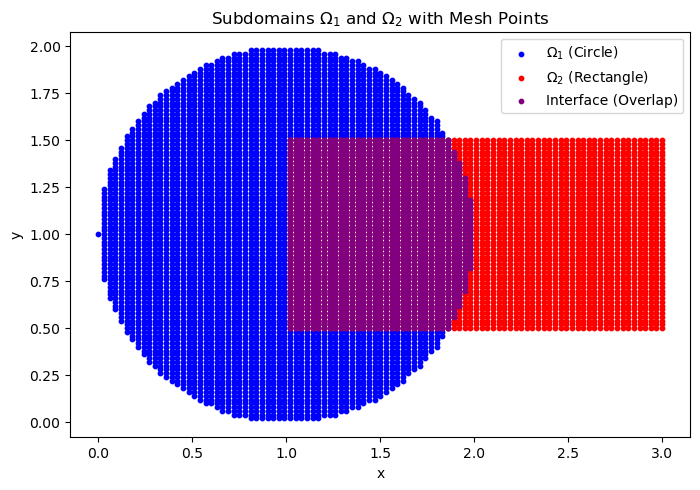

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.sparse import lil_matrix
from scipy.sparse.linalg import spsolve

# parameters
Nx = 101
Ny = 101
x = np.linspace(0,3,Nx)
y = np.linspace(0,2,Ny)
dx = x[1]-x[0]
dy = y[1]-y[0]

X, Y = np.meshgrid(x,y, indexing='ij')  # X[i,j], Y[i,j]

# define the subdomain
def in_circle(x,y):
    return ((x-1)**2+(y-1)**2)<=1.0

def in_rect(x,y):
    return (x>=1.0) & (x<=3.0) & (y>=0.5) & (y<=1.5)

Omega1 = in_circle(X,Y)    # circle mask
Omega2 = in_rect(X,Y)      # rectangle mask
Omega = Omega1 | Omega2
interface = Omega1 & Omega2

X_Omega1 = X[Omega1]
Y_Omega1 = Y[Omega1]
X_Omega2 = X[Omega2]
Y_Omega2 = Y[Omega2]
X_Interface = X[interface]
Y_Interface = Y[interface]

# check if the mask of domain are correct
plt.figure(figsize=(8, 6))
plt.scatter(X_Omega1, Y_Omega1, c='blue', s=10, label=r'$\Omega_1$ (Circle)')
plt.scatter(X_Omega2, Y_Omega2, c='red', s=10, label=r'$\Omega_2$ (Rectangle)')
plt.scatter(X_Interface, Y_Interface, c='purple', s=10, label='Interface (Overlap)')
plt.xlabel('x')
plt.ylabel('y')
plt.title('Subdomains $\Omega_1$ and $\Omega_2$ with Mesh Points')
plt.legend(loc='upper right')
plt.axis('scaled')
plt.show()

Iteration 1: diff1 = 1.052868e+01, diff2 = 8.302512e+00
Iteration 2: diff1 = 2.349185e+00, diff2 = 6.630349e-01
Iteration 3: diff1 = 1.499822e-01, diff2 = 5.035528e-02
Iteration 4: diff1 = 1.332647e-02, diff2 = 4.654902e-03
Iteration 5: diff1 = 1.274536e-03, diff2 = 4.488631e-04
Iteration 6: diff1 = 1.237455e-04, diff2 = 4.365124e-05
Iteration 7: diff1 = 1.205027e-05, diff2 = 4.252084e-06
Iteration 8: diff1 = 1.174130e-06, diff2 = 4.143319e-07
Iteration 9: diff1 = 1.144155e-07, diff2 = 4.037591e-08
Converged!


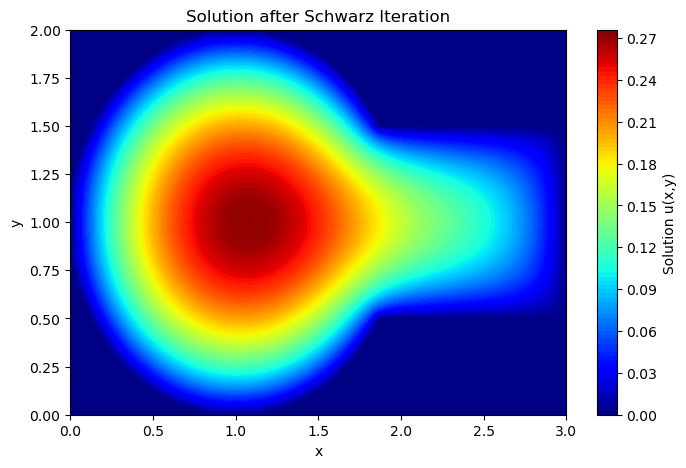

In [ ]:
def solve_subproblem(domain_mask, interface_mask, ext_sol, is_circle=False, circle_params=None):
    """
    Solve subproblem
    - domain_mask: mask of current subdomain
    - interface_mask: mask of interface
    - ext_sol: solution from the other subdomain for interface
    - is_circle: check if domain is a circle
    - circle_params: if circle, (x0, y0, r): center and radius
    """
    # Initialization
    bc_mask = np.zeros((Nx, Ny), dtype=bool)
    bc_values = np.zeros((Nx, Ny), dtype=float)

    x0, y0, r = circle_params if is_circle else (None, None, None)

    for i in range(Nx):
        for j in range(Ny):
            if domain_mask[i, j]:  # Current point belongs to this subdomain
                # Check interface boundary point (get value from the other subdomain)
                if interface_mask[i, j]:
                    # Check whether it is an interface boundary point
                    neighbors = [
                        domain_mask[i - 1, j] if i > 0 else False,
                        domain_mask[i + 1, j] if i < Nx - 1 else False,
                        domain_mask[i, j - 1] if j > 0 else False,
                        domain_mask[i, j + 1] if j < Ny - 1 else False,
                    ]
                    if not all(neighbors):  # At least one neighbor is not in the current subdomain
                        bc_mask[i, j] = True
                        bc_values[i, j] = ext_sol[i, j]

                # Check external boundary point (based on subdomain shape)
                elif is_circle:
                    # Circular boundary condition
                    if abs((X[i, j] - x0)**2 + (Y[i, j] - y0)**2 - r**2) < 1e-6:
                        bc_mask[i, j] = True
                        bc_values[i, j] = 0.0  # Dirichlet condition u = 0
                else:
                    # Rectangular boundary condition
                    neighbors = [
                        domain_mask[i - 1, j] if i > 0 else False,
                        domain_mask[i + 1, j] if i < Nx - 1 else False,
                        domain_mask[i, j - 1] if j > 0 else False,
                        domain_mask[i, j + 1] if j < Ny - 1 else False,
                    ]
                    if not all(neighbors):  # At least one neighbor is not in the current subdomain
                        bc_mask[i, j] = True
                        bc_values[i, j] = 0.0  # Dirichlet condition u = 0

    # Build linear system
    idx_map = -np.ones((Nx, Ny), dtype=int)
    count = 0
    for i in range(Nx):
        for j in range(Ny):
            if domain_mask[i, j] and not bc_mask[i, j]:
                idx_map[i, j] = count
                count += 1

    A = lil_matrix((count, count))
    f = np.zeros(count)

    for i in range(Nx):
        for j in range(Ny):
            if domain_mask[i, j] and not bc_mask[i, j]:
                row = idx_map[i, j]
                A[row, row] = -2 / dx**2 - 2 / dy**2
                f[row] = -1.0

                # Neighbors
                neighbors = [(i + 1, j), (i - 1, j), (i, j + 1), (i, j - 1)]
                for ni, nj in neighbors:
                    if 0 <= ni < Nx and 0 <= nj < Ny and domain_mask[ni, nj]:
                        if bc_mask[ni, nj]:
                            f[row] -= bc_values[ni, nj] / (dx**2 if ni != i else dy**2)
                        else:
                            A[row, idx_map[ni, nj]] = 1 / (dx**2 if ni != i else dy**2)

    # Solve
    u_unknown = spsolve(A.tocsc(), f)
    # Complete the solution
    u = np.zeros((Nx, Ny))
    for i in range(Nx):
        for j in range(Ny):
            if domain_mask[i, j]:
                if bc_mask[i, j]:
                    u[i, j] = bc_values[i, j]
                else:
                    u[i, j] = u_unknown[idx_map[i, j]]
    return u

# Initialize the solution to be zeros
u1 = np.zeros((Nx, Ny))
u2 = np.zeros((Nx, Ny))

# Schwarz Iteration
circle_params = (1.0, 1.0, 1.0)  # Circle parameters: center and radius
max_iter = 20
for k in range(max_iter):
    u1_new = solve_subproblem(Omega1, interface, u2, is_circle=True, circle_params=circle_params)
    u2_new = solve_subproblem(Omega2, interface, u1_new, is_circle=False)

    diff1 = np.linalg.norm(u1_new - u1)
    diff2 = np.linalg.norm(u2_new - u2)

    # Update the solution
    u1, u2 = u1_new, u2_new

    print(f"Iteration {k + 1}: diff1 = {diff1:.6e}, diff2 = {diff2:.6e}")
    if diff1 < 1e-6 and diff2 < 1e-6:
        print("Converged!")
        break

def merge_solutions(u1, u2, Omega1, Omega2):
    """
    Merge the solutions from two subdomains
    """
    u = np.zeros((Nx, Ny))
    for i in range(Nx):
        for j in range(Ny):
            if Omega1[i, j] and Omega2[i, j]:
                # Take average on the overlapping region
                u[i, j] = 0.5 * (u1[i, j] + u2[i, j])
            elif Omega1[i, j]:
                u[i, j] = u1[i, j]
            elif Omega2[i, j]:
                u[i, j] = u2[i, j]
    return u

u = merge_solutions(u1, u2, Omega1, Omega2)

plt.figure(figsize=(8, 5))
plt.contourf(X, Y, u, levels=100, cmap='jet')
plt.colorbar(label='Solution u(x,y)')
plt.xlabel('x')
plt.ylabel('y')
plt.title('Solution after Schwarz Iteration')
plt.show()



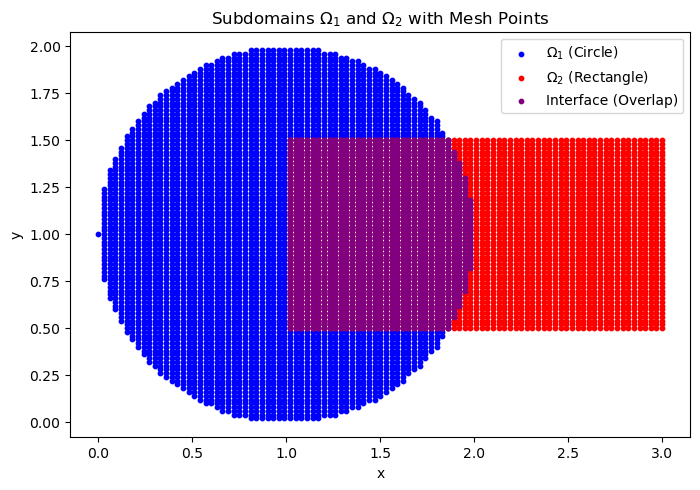

Iteration 1: diff1 = 1.052868e+01, diff2 = 3.795366e+00
Iteration 2: diff1 = 1.650257e+00, diff2 = 5.738685e+00
Iteration 3: diff1 = 7.010975e-01, diff2 = 4.517670e-01
Iteration 4: diff1 = 9.921570e-02, diff2 = 2.114539e-01
Iteration 5: diff1 = 5.077506e-02, diff2 = 3.304689e-02
Iteration 6: diff1 = 8.684242e-03, diff2 = 1.730939e-02
Iteration 7: diff1 = 4.642263e-03, diff2 = 3.028114e-03
Iteration 8: diff1 = 8.279034e-04, diff2 = 1.626792e-03
Iteration 9: diff1 = 4.466330e-04, diff2 = 2.914676e-04
Iteration 10: diff1 = 8.033052e-05, diff2 = 1.573955e-04
Iteration 11: diff1 = 4.341500e-05, diff2 = 2.833467e-05
Iteration 12: diff1 = 7.821564e-06, diff2 = 1.531658e-05
Iteration 13: diff1 = 4.228702e-06, diff2 = 2.759898e-06
Iteration 14: diff1 = 7.620834e-07, diff2 = 1.492186e-06
Iteration 15: diff1 = 4.120464e-07, diff2 = 2.689265e-07
Converged!


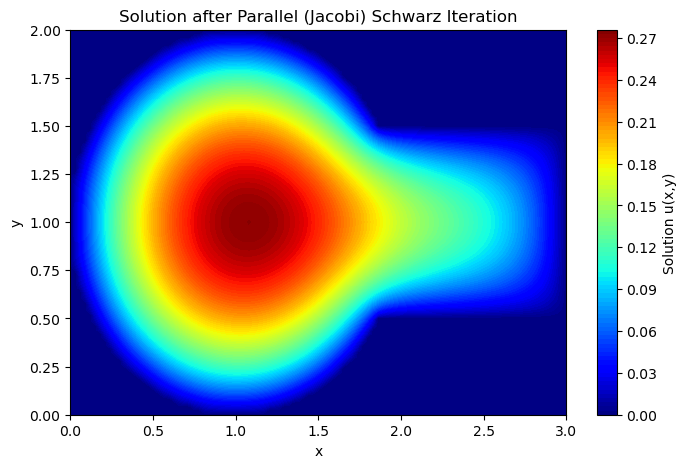

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.sparse import lil_matrix
from scipy.sparse.linalg import spsolve

Nx = 101
Ny = 101
x = np.linspace(0,3,Nx)
y = np.linspace(0,2,Ny)
dx = x[1]-x[0]
dy = y[1]-y[0]

X, Y = np.meshgrid(x,y, indexing='ij')  # X[i,j], Y[i,j]

def in_circle(x,y):
    return ((x-1)**2 + (y-1)**2) <= 1.0

def in_rect(x,y):
    return (x>=1.0) & (x<=3.0) & (y>=0.5) & (y<=1.5)

Omega1 = in_circle(X,Y)    # circle mask
Omega2 = in_rect(X,Y)      # rectangle mask
Omega = Omega1 | Omega2
interface = Omega1 & Omega2

plt.figure(figsize=(8, 6))
plt.scatter(X[Omega1], Y[Omega1], c='blue', s=10, label=r'$\Omega_1$ (Circle)')
plt.scatter(X[Omega2], Y[Omega2], c='red', s=10, label=r'$\Omega_2$ (Rectangle)')
plt.scatter(X[interface], Y[interface], c='purple', s=10, label='Interface (Overlap)')
plt.xlabel('x')
plt.ylabel('y')
plt.title('Subdomains $\Omega_1$ and $\Omega_2$ with Mesh Points')
plt.legend(loc='upper right')
plt.axis('scaled')
plt.show()

# Same as before
def solve_subproblem(domain_mask, interface_mask, ext_sol, 
                     is_circle=False, circle_params=None):
    """
    solve subproblem
    - domain_mask: mask of current subdomain
    - interface_mask: mask of interface
    - ext_sol: solution from the other subdomain for interface
    - is_circle: check if circle
    - circle_params: if circle, (x0, y0, r):center and radius
    """
    bc_mask = np.zeros((Nx, Ny), dtype=bool)
    bc_values = np.zeros((Nx, Ny), dtype=float)

    x0, y0, r = circle_params if is_circle else (None, None, None)

    # 处理边界条件：接口 & 外部边界
    for i in range(Nx):
        for j in range(Ny):
            if domain_mask[i, j]:
                # ----接口上的Dirichlet(来自另一子域)-----
                if interface_mask[i, j]:
                    neighbors = [
                        domain_mask[i - 1, j] if i > 0 else False,
                        domain_mask[i + 1, j] if i < Nx - 1 else False,
                        domain_mask[i, j - 1] if j > 0 else False,
                        domain_mask[i, j + 1] if j < Ny - 1 else False,
                    ]
                    # 如果有邻居不在本子域，则视为“对外开放边界”（即接口，或外部）
                    if not all(neighbors):
                        bc_mask[i, j] = True
                        bc_values[i, j] = ext_sol[i, j]  # 来自另一子域

                # 外部边界点（根据子域几何形状!
                elif is_circle:
                    # 圆形边界：若距离圆周非常接近，就视为边界
                    if abs((X[i, j]-x0)**2 + (Y[i, j]-y0)**2 - r**2) < 1e-6:
                        bc_mask[i, j] = True
                        bc_values[i, j] = 0.0
                else:
                    # 矩形边界：如果某个邻居不在子域里
                    neighbors = [
                        domain_mask[i - 1, j] if i > 0 else False,
                        domain_mask[i + 1, j] if i < Nx - 1 else False,
                        domain_mask[i, j - 1] if j > 0 else False,
                        domain_mask[i, j + 1] if j < Ny - 1 else False,
                    ]
                    if not all(neighbors):
                        bc_mask[i, j] = True
                        bc_values[i, j] = 0.0

    # 建立线性系统
    idx_map = -np.ones((Nx, Ny), dtype=int)
    count = 0
    for i in range(Nx):
        for j in range(Ny):
            if domain_mask[i, j] and not bc_mask[i, j]:
                idx_map[i, j] = count
                count += 1

    from scipy.sparse import lil_matrix
    A = lil_matrix((count, count), dtype=float)
    f = np.zeros(count, dtype=float)

    for i in range(Nx):
        for j in range(Ny):
            if domain_mask[i, j] and not bc_mask[i, j]:
                row = idx_map[i, j]
                # discrete -Δu = 1 --> -2/dx^2 - 2/dy^2
                A[row, row] = -2/dx**2 - 2/dy**2
                f[row] = -1.0  # constant 1

                # neighbors
                neighbors = [(i+1, j), (i-1, j), (i, j+1), (i, j-1)]
                for (ni, nj) in neighbors:
                    if 0 <= ni < Nx and 0 <= nj < Ny and domain_mask[ni, nj]:
                        # 如果邻居是边界点，则移到右端
                        if bc_mask[ni, nj]:
                            # 注意：x方向和y方向的系数不同!
                            if ni != i:
                                f[row] -= bc_values[ni, nj] / dx**2
                            else:
                                f[row] -= bc_values[ni, nj] / dy**2
                        else:
                            # 如果邻居也是未知点，则进系统矩阵
                            col = idx_map[ni, nj]
                            if ni != i:
                                A[row, col] = 1/dx**2
                            else:
                                A[row, col] = 1/dy**2

    # solve linear system
    from scipy.sparse.linalg import spsolve
    u_unknown = spsolve(A.tocsc(), f)

    u_local = np.zeros((Nx, Ny), dtype=float)
    for i in range(Nx):
        for j in range(Ny):
            if domain_mask[i, j]:
                if bc_mask[i, j]:
                    u_local[i, j] = bc_values[i, j]
                else:
                    u_local[i, j] = u_unknown[idx_map[i, j]]

    return u_local

# Schwarz parallel（Jacobi）

u1 = np.zeros((Nx, Ny))
u2 = np.zeros((Nx, Ny))

circle_params = (1.0, 1.0, 1.0)
max_iter = 20
tol = 1e-6

for k in range(max_iter):
    # save the old solution
    u1_old = u1.copy()
    u2_old = u2.copy()

    # use old solution to get new ones
    # On Omega1, use u2_old from the last iteration
    u1_new = solve_subproblem(
        domain_mask=Omega1,
        interface_mask=interface,
        ext_sol=u2_old,
        is_circle=True, 
        circle_params=circle_params
    )

    #On Omega2, use u1_old from the last iteration 
    u2_new = solve_subproblem(
        domain_mask=Omega2,
        interface_mask=interface,
        ext_sol=u1_old,
        is_circle=False
    )

    #compute difference
    diff1 = np.linalg.norm(u1_new - u1)
    diff2 = np.linalg.norm(u2_new - u2)

    #updata
    u1 = u1_new
    u2 = u2_new

    print(f"Iteration {k+1}: diff1 = {diff1:.6e}, diff2 = {diff2:.6e}")
    if diff1 < tol and diff2 < tol:
        print("Converged!")
        break


def merge_solutions(u1, u2, Omega1, Omega2):
    u = np.zeros((Nx, Ny))
    for i in range(Nx):
        for j in range(Ny):
            if Omega1[i, j] and Omega2[i, j]:
                # Overlap area: take the average
                u[i, j] = 0.5*(u1[i, j] + u2[i, j])
            elif Omega1[i, j]:
                u[i, j] = u1[i, j]
            elif Omega2[i, j]:
                u[i, j] = u2[i, j]
    return u

u = merge_solutions(u1, u2, Omega1, Omega2)

plt.figure(figsize=(8, 5))
plt.contourf(X, Y, u, levels=100, cmap='jet')
plt.colorbar(label='Solution u(x,y)')
plt.xlabel('x')
plt.ylabel('y')
plt.title('Solution after Parallel (Jacobi) Schwarz Iteration')
plt.show()


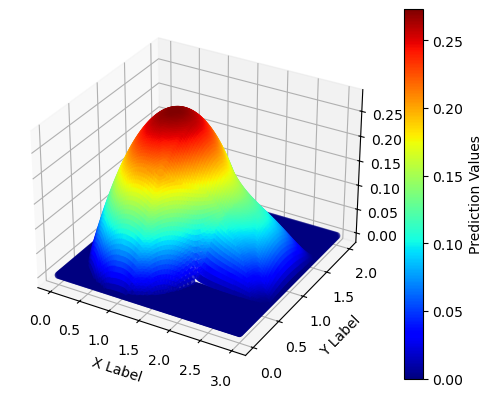

In [5]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

sc = ax.scatter(X, Y, u, c=u, cmap='jet')

plt.colorbar(sc, ax=ax, label='Prediction Values')

ax.set_xlabel('X Label')
ax.set_ylabel('Y Label')
ax.set_zlabel('Prediction')

plt.show()